<a href="https://colab.research.google.com/github/IAmRadium/Similar_password_generation/blob/main/perfectly_working_with_keras%26tf_conditions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Requirements
We need to downgrade both tensorflow and keras, to run the program smoothly.
Required Tensorflow version 1.15.5 

We are using Keras 2.2.4


https://github.com/antonio-f/Generating-names-with-RNN/blob/master/Generating%20names%20with%20recurrent%20neural%20networks/RNN-task.ipynb

In [ ]:
!pip install 'tensorflow<2.0'

In [ ]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
import time
#sys.path.append("..")
import tensorflow.keras.utils
import tqdm.utils
#from keras.utils import np_utils
#import keras
from tensorflow import keras 

print("We are using Keras", keras.__version__)

1.15.5
We are using Keras 2.2.4-tf


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
root_path = 'gdrive/My Drive/Google Colab/' 
#names = open(root_path+'cleaned_rockyou.txt', 'r')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
start_token = " "  # so that the network knows that we're generating a first token

# this is the token for padding,
# we will add fake pad token at the end of names 
# to make them of equal size for further batching
pad_token = "#"

with open(root_path+'cleaned_rockyou.txt') as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]

In [ ]:
print('number of samples:', len(names))
#for x in names[::1000]:
#    print(x)

number of samples: 13679377


max length: 14


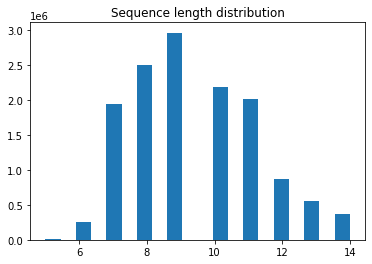

In [ ]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=20);

In [ ]:
from itertools import chain

tokens = set(chain(*map(lambda x: list(x),names))) ### YOUR CODE HERE: all unique characters go here, padding included!
print(len(tokens))
tokens.add(pad_token)

tokens = list(tokens)
n_tokens = len(tokens)
print ('n_tokens:', n_tokens)
print(tokens)


95
n_tokens: 95
['n', 'N', 'U', '\\', 'B', '|', '-', 'K', 't', 'R', '_', '.', '&', 'u', '`', ']', 'q', 'r', ' ', 'b', 'y', '0', 's', '!', '<', 'e', '?', ',', 'l', '$', 'a', 'D', 'j', ':', 'x', '[', '3', 'z', '}', '7', '9', 'M', 'c', '"', "'", '(', '#', 'E', '4', 'A', '=', '*', 'v', 'I', 'X', 'w', 'V', ';', '6', 'i', 'k', 'T', 'p', 'o', 'G', 'Q', '>', ')', '1', 'Z', 'g', '^', '5', 'H', 'h', 'd', 'L', '/', 'C', 'f', 'P', '@', 'W', 'O', 'm', 'J', '+', '{', 'Y', '%', '8', 'S', 'F', '2', '~']


In [ ]:
### YOUR CODE HERE: create a dictionary of {symbol -> its  index in tokens}
token_to_id = {s: idx for idx, s in enumerate(tokens)} 

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

In [ ]:
def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [ ]:
print('\n'.join(names[::2000000]))
print(to_matrix(names[::2000000]))

 123456
 arman\\\\
 rozgwiazda
 lemmings2
 eeza5783
 Tony15
 31322210
[[18 68 93 36 48 72 58 46 46 46 46]
 [18 30 17 84 30  0  3  3  3  3 46]
 [18 17 63 37 70 55 59 30 37 75 30]
 [18 28 25 84 84 59  0 70 22 93 46]
 [18 25 25 37 30 72 39 90 36 46 46]
 [18 61 63  0 20 68 72 46 46 46 46]
 [18 36 68 36 93 93 93 68 21 46 46]]


In [ ]:
#import keras
from tensorflow.keras import backend as K
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s


In [ ]:
# NOTICE: If you get any error, like "AttributeError: module 'tensorflow' has no attribute 'get_default_session'" you just have to downgrade tensorflow
#using this command "!pip install 'tensorflow<2.0'"
#Similarly if you get any error regarding keras_utils, you have to downgrade the keras too.
s = reset_tf_session()
#from keras import backend as K
#K.clear_session()

In [ ]:
from tensorflow.keras.layers import concatenate, Dense, Embedding

rnn_num_units = 128  # size of hidden state
embedding_size = 14  # We need to set it the max password length; here it is 14

# Let's create layers for our recurrent network
# Note: we create layers but we don't "apply" them yet (this is a "functional API" of Keras)
# Note: set the correct activation (from keras.activations) to Dense layers!

# an embedding layer that converts character ids into embeddings
embed_x = Embedding(n_tokens, embedding_size)

# a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
get_h_next = Dense(rnn_num_units, activation='relu')### YOUR CODE HERE

# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas = Dense(n_tokens, activation='softmax')### YOUR CODE HERE

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    We'll call this method repeatedly to produce the whole sequence.
    
    You're supposed to "apply" above layers to produce new tensors.
    Follow inline instructions to complete the function.
    """
    # convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    
    # concatenate x_t embedding and previous h_t state
    x_and_h = concatenate([x_t_emb, h_t])### YOUR CODE HERE
    
    # compute next state given x_and_h
    h_next = get_h_next(x_and_h)### YOUR CODE HERE
    
    # get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next) ### YOUR CODE HERE
    
    return output_probas, h_next

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
# combine predicted_probas into [batch, time, n_tokens] tensor
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]


Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# flatten predictions to [batch*time, n_tokens]
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])

# flatten answers (next tokens) and one-hot encode them
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

In [ ]:
# Define the loss as categorical cross-entropy (e.g. from keras.losses).
# Mind that predictions are probabilities and NOT logits!
# Remember to apply tf.reduce_mean to get a scalar loss!
loss = tf.reduce_mean(keras.losses.categorical_crossentropy(answers_matrix, predictions_matrix))### YOUR CODE HERE

optimize = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


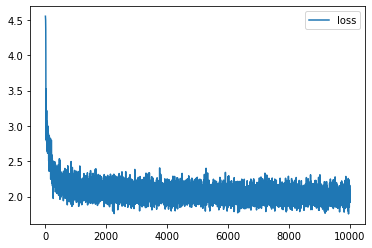


Training time for 10000 iterations: 105.97900676727295  sec.


In [ ]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())
training_time_file = open(root_path+'training_time.txt','a')
batch_size = 32
history = []
iterations = 10000
start_time = time.time()
for i in range(iterations):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()
print("\nTraining time for %d iterations: %s  sec." %(iterations, (time.time() - start_time)))
training_time_file.write(str(iterations)+" "+str((time.time() - start_time)))
training_time_file.write('\n')
training_time_file.close()
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"

In [ ]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  # we will update hidden state in this variable

# For sampling we need to define `rnn_one_step` tensors only once in our graph.
# We reuse all parameters thanks to functional API usage.
# Then we can feed appropriate tensor values using feed_dict in a loop.
# Note how different it is from training stage, where we had to unroll the whole sequence for backprop.
next_probs, next_h = rnn_one_step(x_t, h_t)

In [ ]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    '''
    This function generates text given a `seed_phrase` as a seed.
    Remember to include start_token in seed phrase!
    Parameter `max_length` is used to set the number of characters in prediction.
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [ ]:
pw_file = open(root_path+'generated_passw.txt','a')
gen_time_file = open(root_path+'generation_time.txt','a')
start_time = time.time()
number_of_passwd_to_generate = 100            ######## change here to generate more passwords
for _ in range(number_of_passwd_to_generate):
    passwd = generate_sample()
    pw_file.write(passwd)
    pw_file.write('\n')
    #print(generate_sample())
pw_file.close()
print("\nTime required to generate %d passwords: %s sec." %(number_of_passwd_to_generate,(time.time() - start_time)))
gen_time_file.write(str(number_of_passwd_to_generate)+" "+str((time.time() - start_time)))
gen_time_file.write('\n')
gen_time_file.close()